In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df['Length'] = [len(headline) for headline in df['Headline']]
df.head()

,URLs,Headline,Body,Label,Length
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,42
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1,66
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1,60
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1,68
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1,43


In [4]:
print(df['Length'].describe())

count    4009.000000
mean       60.104016
std        22.660900
min         6.000000
25%        48.000000
50%        60.000000
75%        69.000000
max       653.000000
Name: Length, dtype: float64


In [5]:
filter = df['Label'] == 1
pos = df[filter]
print(len(pos))

filter = df['Label'] == 0
neg = df[filter]
print(len(neg))

mean = min(len(pos), len(neg))

p_data = pos.sample(n = mean)
print(len(p_data))

n_data = neg.sample(n = mean)
print(len(n_data))

1872
2137
1872
1872


In [6]:
test_split = 0.3
train_split = 1 - test_split

p_train_data = p_data.sample(frac=train_split)
p_test_data = p_data.drop(p_train_data.index)

n_train_data = n_data.sample(frac=train_split)
n_test_data = n_data.drop(n_train_data.index)

train_data = pd.concat([p_train_data, n_train_data])
test_data = pd.concat([p_test_data, n_test_data])

train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

x_train_data = train_data['Headline'].fillna('')
y_train_data = train_data['Label']
x_test_data = test_data['Headline'].fillna('')
y_test_data = test_data['Label']

In [7]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [8]:
token_num = 4000

data_length = int(df['Length'].describe()['mean'])

output_length = 32

dropout = 0.2
lstm_dim = 256

In [9]:
token = Tokenizer(num_words = token_num, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
token.fit_on_texts(x_train_data)

In [10]:
x_train_sequence = token.texts_to_sequences(x_train_data)
x_test_sequence = token.texts_to_sequences(x_test_data)

In [11]:
x_train = sequence.pad_sequences(x_train_sequence, maxlen = data_length)
x_test = sequence.pad_sequences(x_test_sequence, maxlen = data_length)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM
from keras.callbacks import EarlyStopping

In [13]:
model = Sequential()
model.add(Embedding(output_dim = output_length, input_dim=token_num, input_length=data_length))
model.add(Dropout(dropout))
model.add(LSTM(lstm_dim))
model.add(Dropout(dropout))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 32)            128000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

In [15]:
train_history = model.fit(x=x_train, y=y_train_data, validation_split=0.3, epochs=20, batch_size=100, verbose=1, callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1833 samples, validate on 787 samples
Epoch 1/20
1833/1833 [==============================] - 4s 2ms/step - loss: 0.6913 - accuracy: 0.5281 - val_loss: 0.6834 - val_accuracy: 0.5604
Epoch 2/20
1833/1833 [==============================] - 2s 1ms/step - loss: 0.6431 - accuracy: 0.6727 - val_loss: 0.5763 - val_accuracy: 0.7319
Epoch 3/20
1833/1833 [==============================] - 2s 1ms/step - loss: 0.5513 - accuracy: 0.7954 - val_loss: 0.5225 - val_accuracy: 0.7675
Epoch 4/20
1833/1833 [==============================] - 2s 1ms/step - loss: 0.3506 - accuracy: 0.8843 - val_loss: 0.3882 - val_accuracy: 0.8348
Epoch 5/20
1833/1833 [==============================] - 2s 1ms/step - loss: 0.1746 - accuracy: 0.9389 - val_loss: 0.3725 - val_accuracy: 0.8488
Epoch 6/20
1833/1833 [==============================] - 2s 1ms/step - loss: 0.0995 - accuracy: 0.9645 - val_loss: 0.3775 - val_accuracy: 0.8488
Epoch 7/20
1833/1833 [==============================] - 2s 1ms/step - loss: 0.0580 - accu

In [16]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

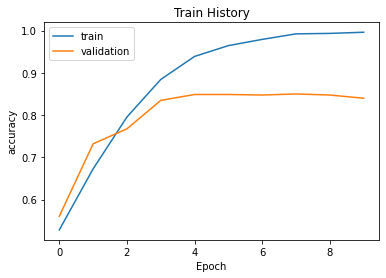

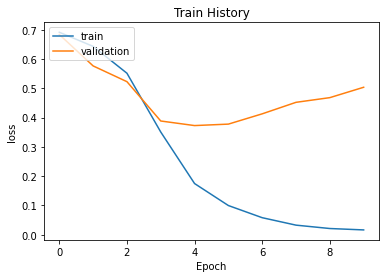

In [17]:
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [18]:
score = model.evaluate(x=x_test, y=y_test_data)
score[1]

1124/1124 [==============================] - 0s 315us/step


0.8238434195518494